<b><p style="font-size: XX-large"><font color = "green">K-Means Clustering for Water Treatment Plans</font></p></b> </div>
<b><p style="font-size: X-large"><font color = "green">Andrew Cai (cai.and@northeastern.edu)</font></p></b> </div>
<b><p style="font-size: X-large"><font color = "green">December 13, 2024</font></p></b> </div>

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (silhouette_score, 
                             calinski_harabasz_score, 
                             davies_bouldin_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

# Data Exploration

In [2]:
# Load in dataset
wq_df = pd.read_csv("waterQuality1.csv")
wq_df.head(5)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [3]:
# Initial Metadata
wq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

# Data Cleaning

In [4]:
# Convert all values to floats
wq_df = wq_df.apply(pd.to_numeric, errors='coerce')

# Only want unsafe water
wq_df_unsafe = wq_df.loc[wq_df['is_safe'] == 0].copy()

# Drop any NA values
wq_df_unsafe.dropna(inplace=True)

# Reset index
wq_df_unsafe.reset_index(drop=True, inplace=True)

# Check metadata
wq_df_unsafe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7084 entries, 0 to 7083
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7084 non-null   float64
 1   ammonia      7084 non-null   float64
 2   arsenic      7084 non-null   float64
 3   barium       7084 non-null   float64
 4   cadmium      7084 non-null   float64
 5   chloramine   7084 non-null   float64
 6   chromium     7084 non-null   float64
 7   copper       7084 non-null   float64
 8   flouride     7084 non-null   float64
 9   bacteria     7084 non-null   float64
 10  viruses      7084 non-null   float64
 11  lead         7084 non-null   float64
 12  nitrates     7084 non-null   float64
 13  nitrites     7084 non-null   float64
 14  mercury      7084 non-null   float64
 15  perchlorate  7084 non-null   float64
 16  radium       7084 non-null   float64
 17  selenium     7084 non-null   float64
 18  silver       7084 non-null   float64
 19  uraniu

In [5]:
# Preview cleaned data
wq_df_unsafe.sample(5)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
1111,2.98,15.24,0.19,3.18,0.070,1.79,0.25,1.12,1.15,0.69,...,0.121,2.84,1.54,0.003,32.70,7.55,0.10,0.01,0.03,0.0
3139,0.05,12.53,0.48,3.25,0.050,1.16,0.18,0.02,0.27,0.08,...,0.131,12.50,1.89,0.001,54.01,6.15,0.02,0.42,0.05,0.0
1814,0.11,11.87,0.03,3.96,0.007,7.17,0.27,1.50,0.23,0.18,...,0.166,16.15,1.36,0.003,15.81,4.98,0.07,0.47,0.07,0.0
961,2.53,7.37,0.32,2.04,0.020,4.77,0.62,0.05,1.37,0.94,...,0.151,8.74,1.47,0.000,47.67,5.56,0.07,0.17,0.03,0.0
3302,0.07,14.72,0.08,2.61,0.020,0.01,0.09,0.08,0.73,0.00,...,0.132,4.13,0.13,0.007,3.20,0.21,0.05,0.03,0.05,0.0


In [6]:
# No longer need is_safe feature
wq_df_unsafe.drop('is_safe', axis=1, inplace=True)

# Feature Engineering

In [7]:
# Need to scale values for comparison
scaler = StandardScaler()

# Extract features
columns = list(wq_df_unsafe.columns)

In [8]:
# Standarize features
wq_df_unsafe_standardized = scaler.fit_transform(wq_df_unsafe)

# Generate standardized DataFrame
wq_df_unsafe_standardized = pd.DataFrame(wq_df_unsafe_standardized, columns=columns)

# Preview data
wq_df_unsafe_standardized.sample(5)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
397,1.844868,0.713887,-0.433120,1.197642,0.951020,2.522103,2.229577,-0.546872,0.984013,-0.974828,-0.899263,0.211902,0.113677,0.476204,-1.431364,1.262747,-0.575482,-1.389360,0.901890,0.543881
6098,-0.411207,1.229198,-0.394675,-0.617318,1.231681,-0.725149,-0.527166,-0.135602,0.319414,1.021261,0.836814,1.411890,0.979765,0.986754,0.259840,-0.854657,-0.562561,1.041848,-0.513012,0.171301
5753,-0.446597,1.653571,-0.548457,-0.642067,0.389700,-0.764653,-0.640456,1.235297,1.419440,-0.702634,-0.886110,-0.970943,1.112034,-0.323658,-1.769604,-0.491023,-1.023412,-0.347413,-0.583757,0.171301
850,0.296581,0.552221,0.066670,0.290162,0.109039,1.767571,1.096669,1.753192,0.892345,-0.974828,1.573331,-0.902372,-1.038692,0.254965,0.936321,1.539775,0.755386,-0.694729,1.680086,-1.319021
6218,-0.437749,-1.302446,-0.433120,-1.128807,0.109039,-0.772554,-0.715984,-0.120370,-0.803529,1.293455,1.073551,-0.508090,0.543097,0.306020,-0.078401,-0.622042,-0.963114,-1.736675,-0.654502,-0.573860


# Helper Functions

## Elbow Plot

In [9]:
def elbow_plot(num_clusters, data, rs):
    """
    Displays Elbow Plot of K-Means Model

    Parameters:
    num_clusters (integer): Up to Number of Clusters to Evaluate.
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    rs (integer): Random State for K-Means model.

    Returns:
    None
    """
    # Initialize list to store inertia
    inertia = []
    # Initialize number of clusters
    clusters = [i for i in range(1, num_clusters+1)]
    
    # Train K-Means and get Inertia for each number of clusters
    for k in clusters:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        kmeans.fit(data)
        # .inertia_ gives WCSS for the current K
        inertia.append(kmeans.inertia_)  

    # Plot the Elbow Plot
    plt.figure(figsize=(10, 6))
    plt.plot(clusters, inertia, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.xticks(clusters)
    plt.show()

## Silhouette Plot

In [10]:
def silo_plot(num_clusters, data, rs):
    """
    Displays Silhouette Plot of K-Means Model

    Parameters:
    num_clusters (integer): Up to Number of Clusters to Evaluate.
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    rs (integer): Random State for K-Means model.

    Returns:
    None
    """
    # Initialize empty list for Silhouette Scores
    silhouette_scores = []
    # Initialize number of clusters
    clusters = [i for i in range(2, num_clusters+1)]

    # Train K-Means and get Silhouette Score for each number of clusters
    for k in clusters:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(clusters, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.xticks(clusters)
    plt.show()

## PCA Plot

In [11]:
def pca_plot(data, variance):
    """
    Displays PCA Plot of Variance vs # of Features

    Parameters:
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    variance (float): Target variance wanted.

    Returns:
    None
    """
    # Initialize PCA
    pca = PCA(n_components=None)  # Start with all components to analyze explained variance
    data_pca = pca.fit_transform(data)

    # Inspect the explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    # Show Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
    plt.xticks(np.arange(1, len(data.columns)+1, 1))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.axhline(y=variance, color='r', linestyle='--', label=f'{variance*100: 0.2f}% Variance')
    plt.legend()
    plt.show()

## PCA Reduction

In [12]:
def pca_reduced(data, n):
    """
    Returns DataFrame of Reduced Dataset based on n Principal Components

    Parameters:
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    n (integer): Number of Principal Components.

    Returns:
    data reduced (pd.DataFrame): Reduced DataFrame.
    """
    # Set the number of components to the chosen value (e.g., 5)
    pca = PCA(n_components=n)
    data_reduced = pca.fit_transform(data)
    
    return data_reduced

## t-SNE Plots

In [13]:
def tsne_plot(num_clusters, data, rs):
    """
    Displays t-SNE Plot of K-Means Model

    Parameters:
    num_clusters (integer): Up to Number of Clusters to Evaluate.
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    rs (integer): Random State for K-Means model.

    Returns:
    None
    """
    # Train K-Means model
    kmeans = KMeans(n_clusters=num_clusters, random_state=rs)
    labels = kmeans.fit_predict(data)

    # Instantiate TSNE
    tsne = TSNE(n_components=num_clusters, random_state=rs)
    data_2d = tsne.fit_transform(data)

    # Plot t-SNE
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='tab10')
    plt.title('t-SNE Visualization of Clusters')
    plt.show()

## K-Means Evaluation

In [14]:
def kmeans_eval(data, min_clusters, max_clusters, rs):
    """
    Plots Calinski-Harabasz and Davies-Bouldin Scores for Cluster sizes of model

    Parameters:
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    min_clusters (integer): Minimum Number of Clusters to Evaluate.
    max_clusters (integer): Maximum Number of Clusters to Evaluate.
    rs (integer): Random State for K-Means model.

    Returns:
    None
    """
    # Initialize empty list to store scores
    ch_scores = []
    db_scores = []

    # Initialize Clusters
    clusters = [i for i in range(min_clusters, max_clusters+1)]

    #Train K-Means model and store scores
    for k in clusters:
        kmeans = KMeans(n_clusters=k, random_state=rs, n_init=10)
        cluster_labels = kmeans.fit_predict(data)
        ch = calinski_harabasz_score(data, cluster_labels)
        ch_scores.append(ch)
        db = davies_bouldin_score(data, cluster_labels)
        db_scores.append(db)

    # Display Score Plots
    plt.figure(figsize=(12, 6))

    #plot 1:
    plt.subplot(1, 2, 1)
    plt.plot(clusters, ch_scores, marker='o')
    plt.title('CH Score for Optimal K')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('CH Score')
    plt.xticks(clusters)

    #plot 2:
    plt.subplot(1, 2, 2)
    plt.plot(clusters, db_scores, marker='o')
    plt.title('DB Score for Optimal K')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('DB Score')
    plt.xticks(clusters)

    plt.show()

    print(f"Highest Calinski-Harabasz Score: {np.max(ch_scores): 0.2f} at {clusters[np.argmax(ch_scores)]} Clusters")
    print(f"Lowest Davies-Bouldin Score: {np.min(db_scores): 0.2f} at {clusters[np.argmin(db_scores)]} Clusters")

## K-Means Outputs

In [15]:
def kmeans_outputs(num_clusters, data, rs):
    """
    Outputs various summaries of K-Means Model

    Parameters:
    num_clusters (integer): Number of Clusters to Evaluate.
    data (pd.DataFrame): DataFrame of Dataset to be Examined.
    rs (integer): Random State for K-Means model.

    Returns:
    cluster_sizes (dict): Size of each Cluster
    centroid_dict (dict): Centroid of each Cluster
    cluster_summary (pd.DataFrame): Mean of Features in each Cluster
    metrics (dict): Metrics to Evaluate Model
    """
    # Train K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=rs, n_init=10)
    labels = kmeans.fit_predict(data)
    unique, counts = np.unique(labels, return_counts=True)
    
    # Cluster sizes
    cluster_sizes = dict(zip(unique, counts))

    # Access centroids from the K-Means model
    centroids = kmeans.cluster_centers_
    # Store centroids
    centroid_dict = {i: centroid for i, centroid in enumerate(centroids)}

    # Add cluster labels to the DataFrame
    cluster_properties = data
    cluster_properties["Cluster"] = labels
    # Compute Mean features for each cluster
    cluster_summary = cluster_properties.groupby("Cluster").mean()

    # Metrics
    metrics = {}
    if num_clusters > 1:
        metrics["Silhouette Score"] = np.round(silhouette_score(data, labels), 2)
        metrics["Davies-Bouldin Index"] = np.round(davies_bouldin_score(data, labels), 2)
        metrics["Calinski-Harabasz Index"] = np.round(calinski_harabasz_score(data, labels), 2)
    else:
        metrics["Silhouette Score"] = None
        metrics["Davies-Bouldin Index"] = None
        metrics["Calinski-Harabasz Index"] = None

    return cluster_sizes, centroid_dict, cluster_summary, metrics

# Standardized Data

## Optimal Clusters - Elbow Method

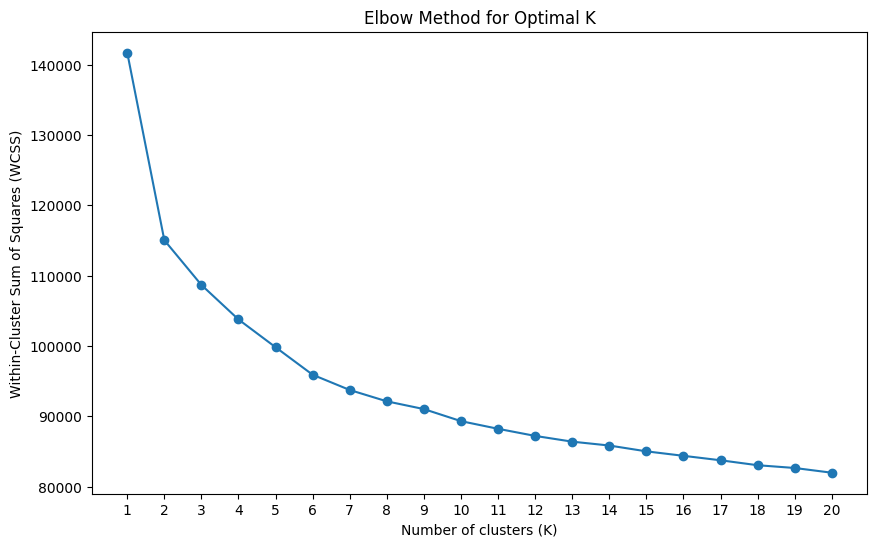

In [16]:
# Plot Elbow Method
elbow_plot(20, wq_df_unsafe_standardized, 42)

## Optimal Clusters - Silhouette Method

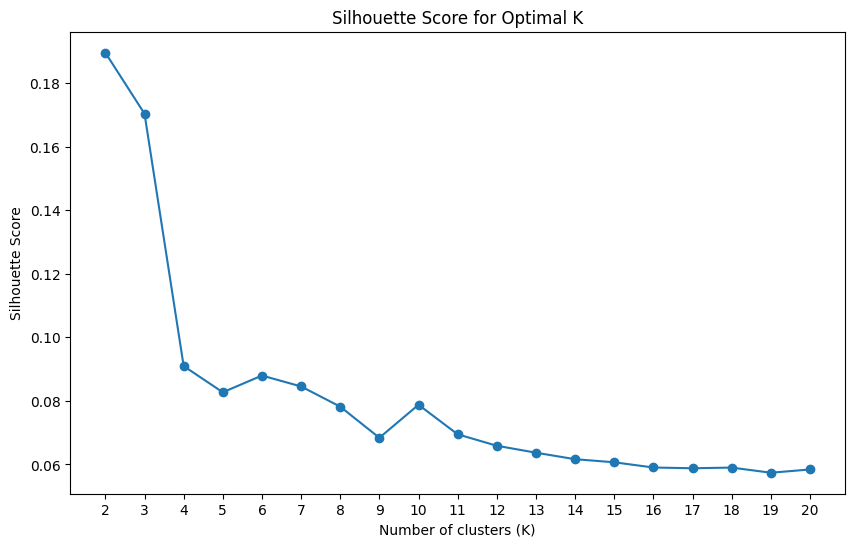

In [17]:
# Plot Silhouette Method
silo_plot(20, wq_df_unsafe_standardized, 42)

# Binary Data

In [18]:
# Store safety thresholds for each feature
thresholds = {
    'aluminium': 2.8,
    'ammonia': 32.5,
    'arsenic': 0.01,
    'barium': 2,	
    'cadmium': 0.005,
    'chloramine': 4,
    'chromium': 0.1,	
    'copper': 1.3,	
    'flouride': 1.5,	
    'bacteria': 0,	
    'viruses': 0,	
    'lead': 0.015,	
    'nitrates': 10,	
    'nitrites': 1,	
    'mercury': 0.002,	
    'perchlorate': 56,	
    'radium': 5,	
    'selenium': 0.5,	
    'silver': 0.1,	
    'uranium': 0.3
}

In [19]:
# Binary Feature Conversion
wq_df_unsafe_binary = wq_df_unsafe.copy()
wq_df_unsafe_binary = wq_df_unsafe_binary.apply(lambda x: (x > thresholds[x.name]).astype(int))

# Preview Data
wq_df_unsafe_binary.sample(5)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
1842,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,1,0
95,0,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,0,0,0
348,1,0,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,0,1,0
4206,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
3518,0,0,1,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0


## Optimal Clusters - Elbow Method

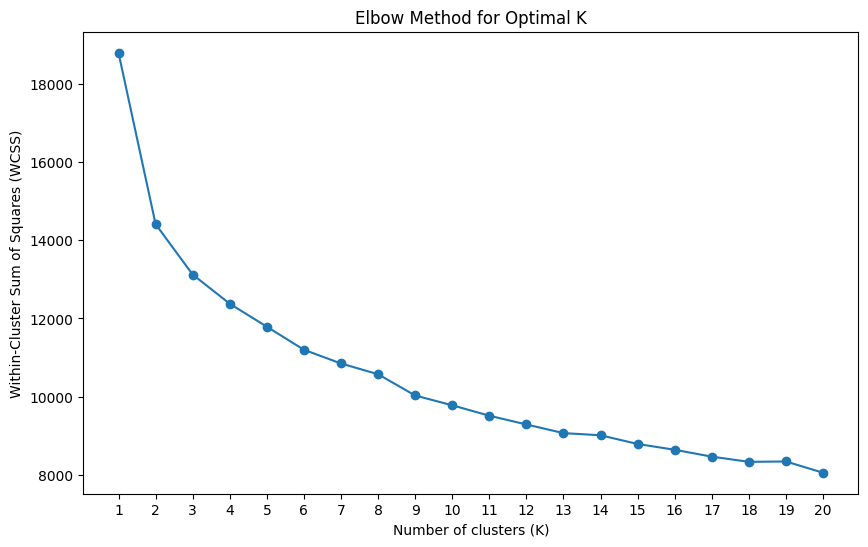

In [20]:
# Plot Elbow Method
elbow_plot(20, wq_df_unsafe_binary, 42)

## Optimal Clusters - Silhouette Method

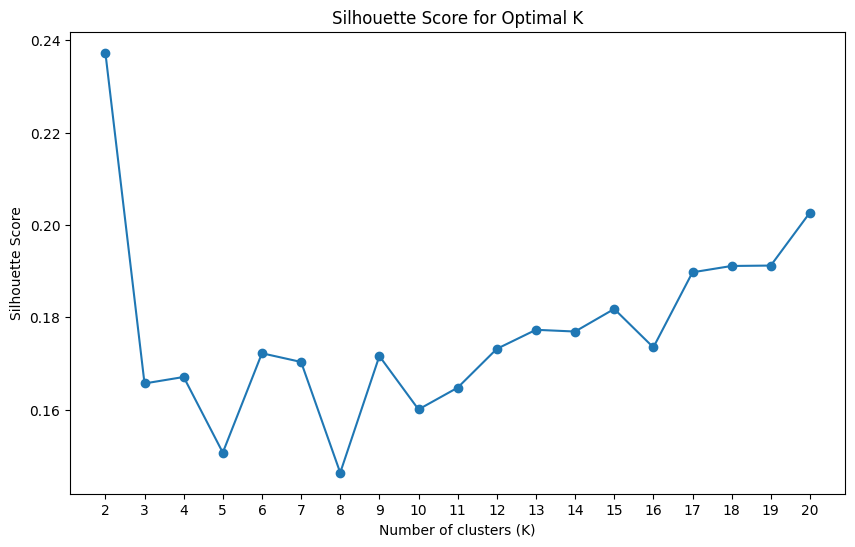

In [21]:
# Plot Silhouette Method
silo_plot(20, wq_df_unsafe_binary, 42)

# Principle Component Analysis

## Standardized Data

### PCA Plot

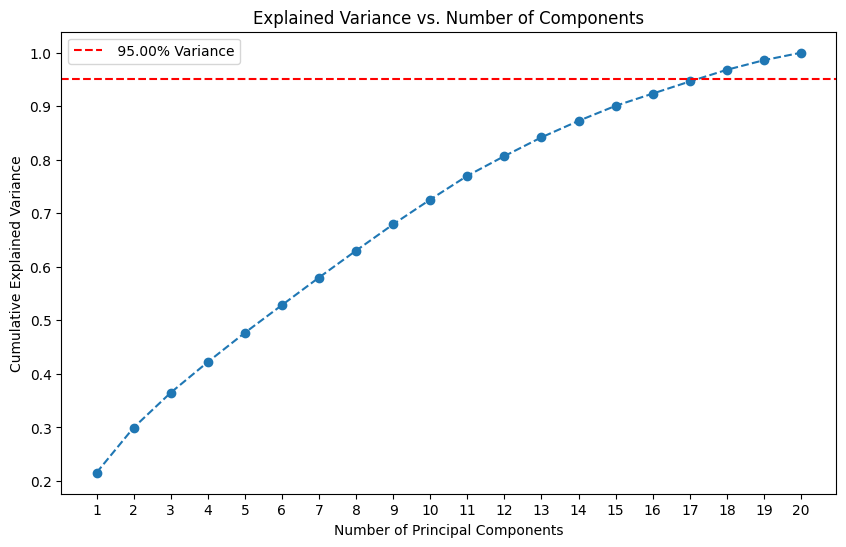

In [22]:
# Plot PCA
pca_plot(wq_df_unsafe_standardized, 0.95)

In [23]:
# PCA Reduction
wq_df_unsafe_standardized_red = pca_reduced(wq_df_unsafe_standardized, 17)

### Optimal Clusters - Elbow Method

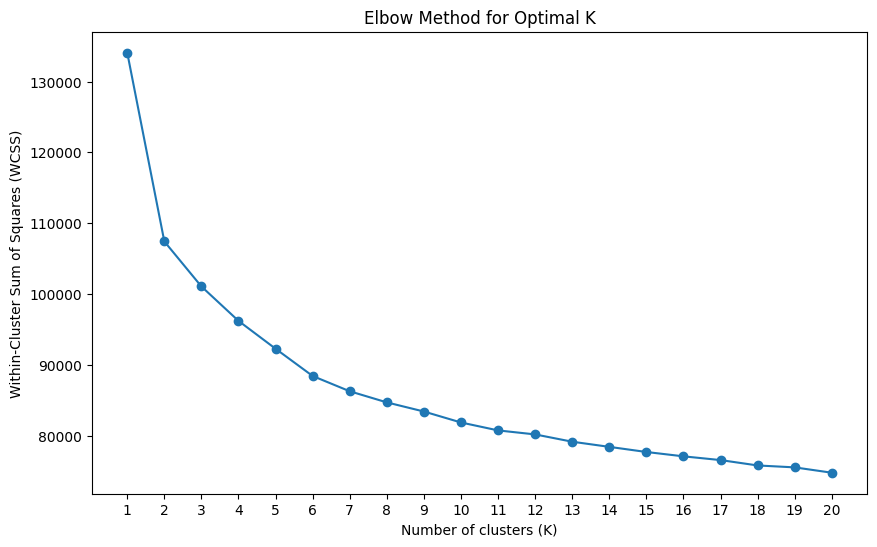

In [24]:
# Plot Elbow Method
elbow_plot(20, wq_df_unsafe_standardized_red, 42)

### Optimal Clusters - Silhouette Method

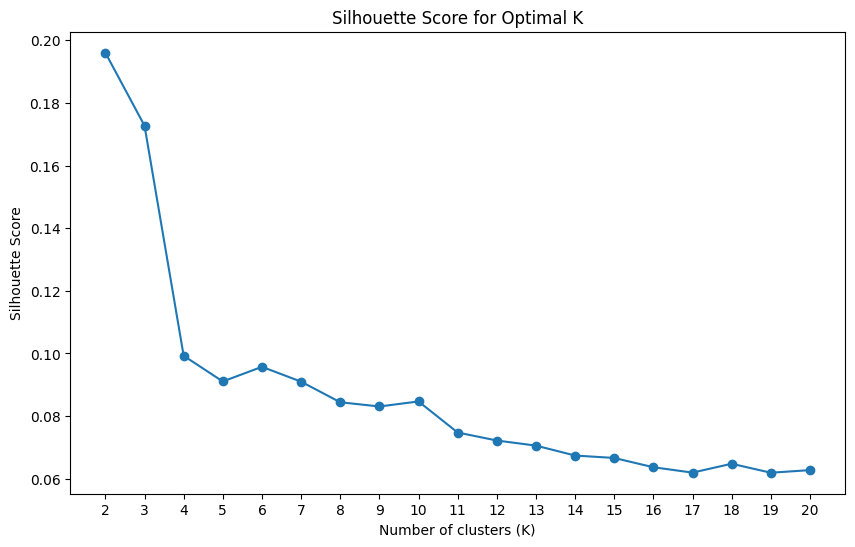

In [25]:
# Plot Silhouette Method
silo_plot(20, wq_df_unsafe_standardized_red, 42)

## Binary Data

### PCA Plot

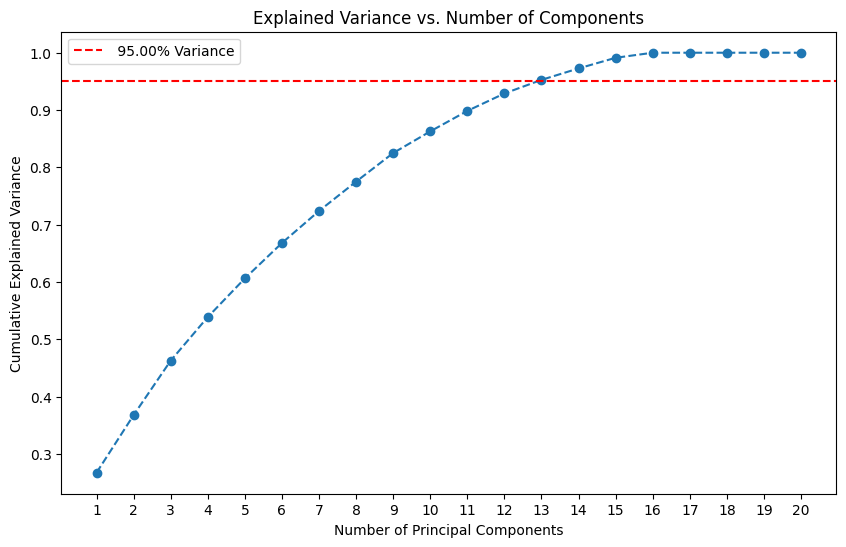

In [26]:
# Plot PCA
pca_plot(wq_df_unsafe_binary, 0.95)

In [27]:
# PCA Reduction
wq_df_unsafe_binary_red = pca_reduced(wq_df_unsafe_binary, 13)

### Optimal Clusters - Elbow Method

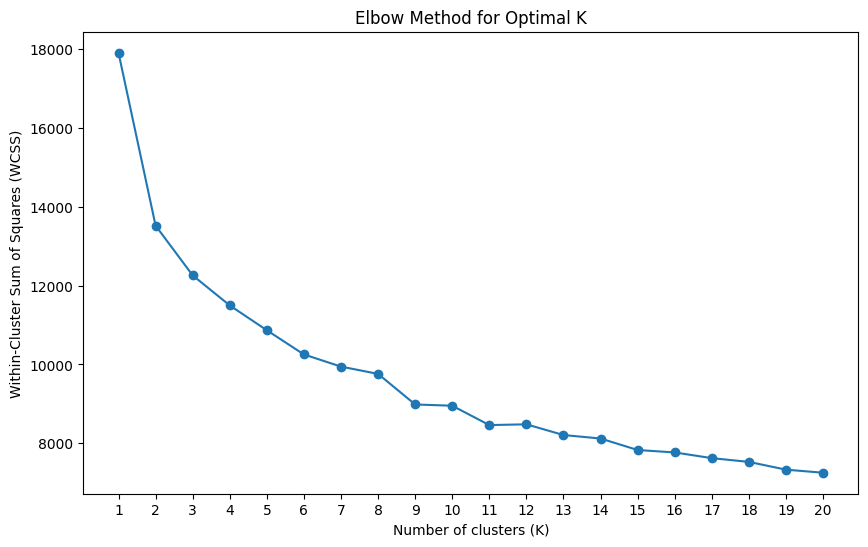

In [28]:
# Plot Elbow Method
elbow_plot(20, wq_df_unsafe_binary_red, 42)

### Optimal Clusters - Silhouette Method

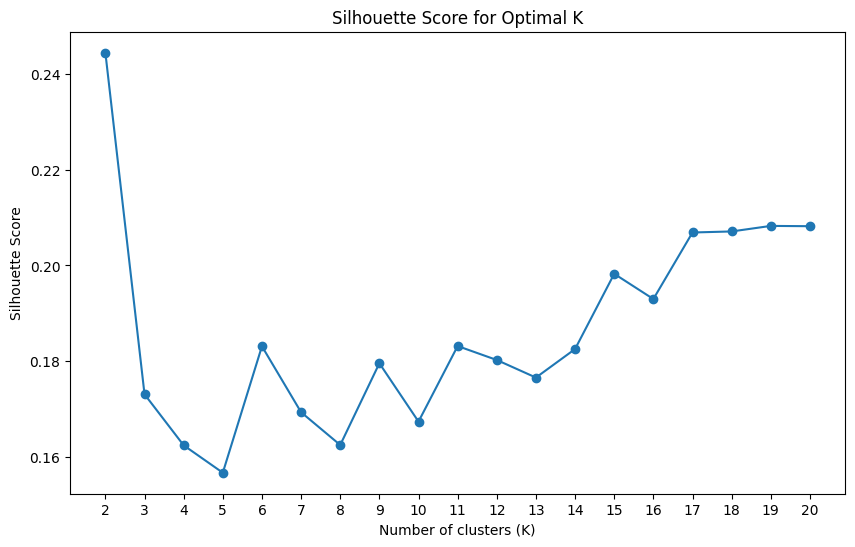

In [29]:
# Plot Silhouette Method
silo_plot(20, wq_df_unsafe_binary_red, 42)

# t-SNE Analysis

## Original Unsafe Data

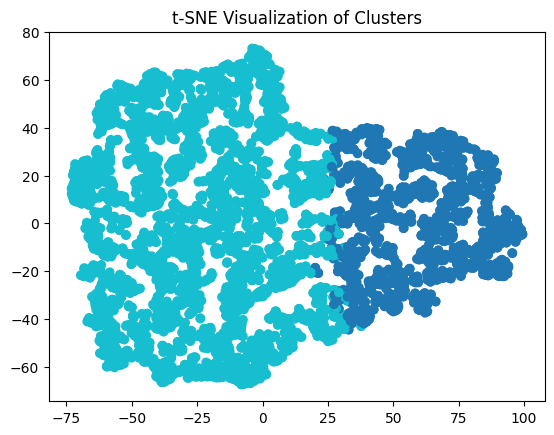

In [30]:
# t-SNE Plot for 2 Clusters
tsne_plot(2, wq_df_unsafe, 42)

## Standardized Data

### All Features

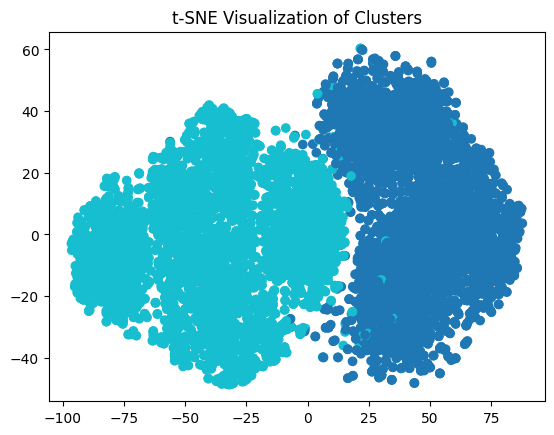

In [31]:
# t-SNE Plot for 2 Clusters
tsne_plot(2, wq_df_unsafe_standardized, 42)

### Reduced Features

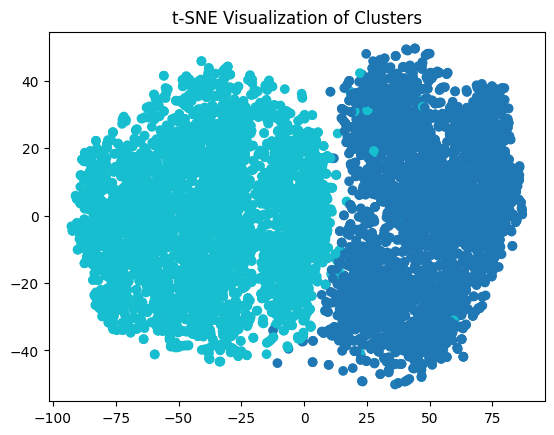

In [32]:
# t-SNE Plot for 2 Clusters
tsne_plot(2, wq_df_unsafe_standardized_red, 42)

## Binary Data

### All Features

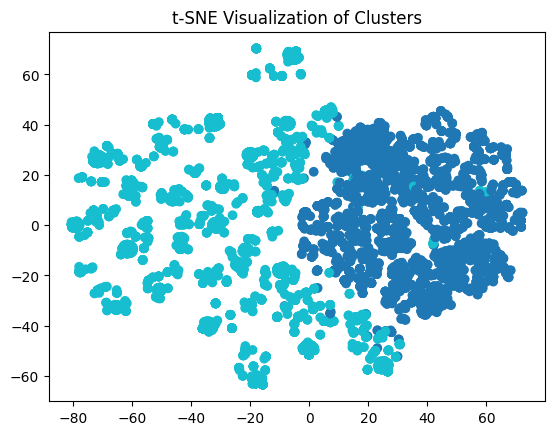

In [33]:
# t-SNE Plot for 2 Clusters
tsne_plot(2, wq_df_unsafe_binary, 42)

### Reduced Features

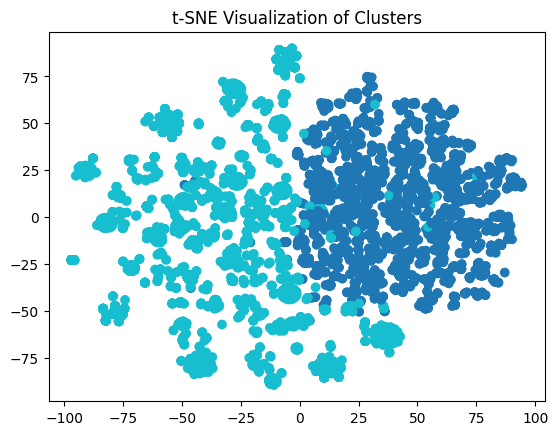

In [34]:
# t-SNE Plot for 2 Clusters
tsne_plot(2, wq_df_unsafe_binary_red, 42)

# Additional Optimal K Evaluation

## Standardized Data

### All Features

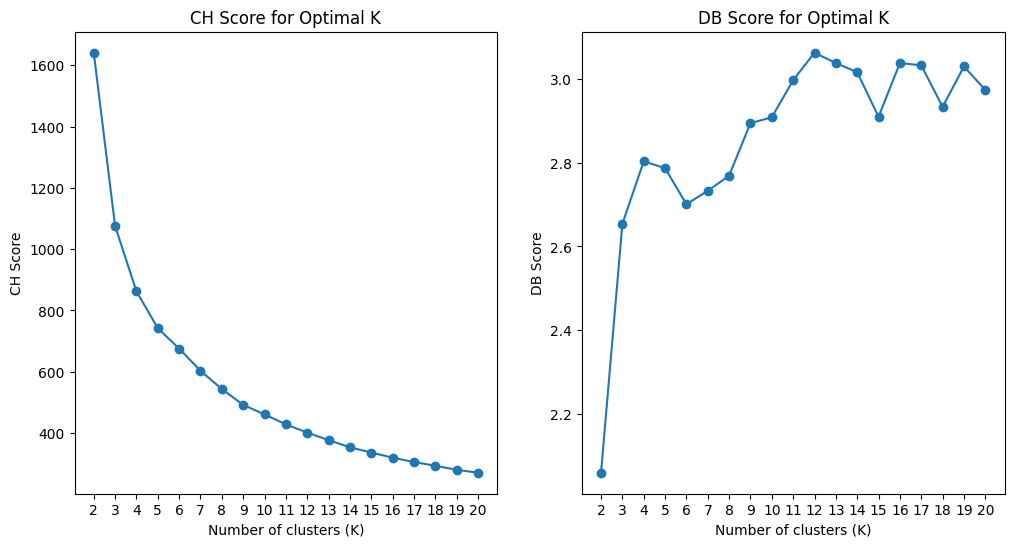

Highest Calinski-Harabasz Score:  1640.88 at 2 Clusters
Lowest Davies-Bouldin Score:  2.06 at 2 Clusters


In [35]:
# Evaluate scores for number of clusters
kmeans_eval(wq_df_unsafe_standardized, 2, 20, 42)

### Reduced Features

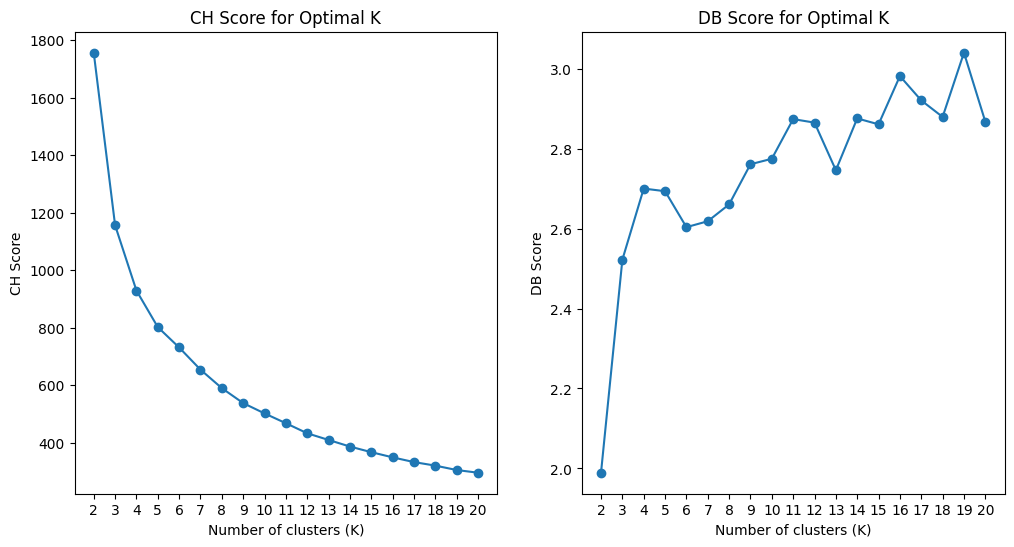

Highest Calinski-Harabasz Score:  1756.96 at 2 Clusters
Lowest Davies-Bouldin Score:  1.99 at 2 Clusters


In [36]:
# Evaluate scores for number of clusters
kmeans_eval(wq_df_unsafe_standardized_red, 2, 20, 42)

## Binary Data

### All Features

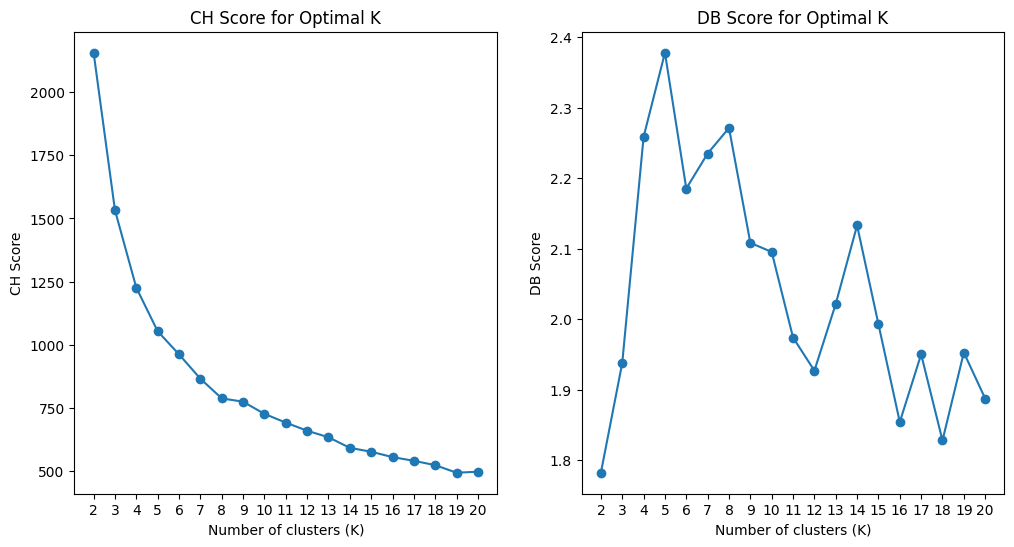

Highest Calinski-Harabasz Score:  2156.27 at 2 Clusters
Lowest Davies-Bouldin Score:  1.78 at 2 Clusters


In [37]:
# Evaluate scores for number of clusters
kmeans_eval(wq_df_unsafe_binary, 2, 20, 42)

### Reduced Features

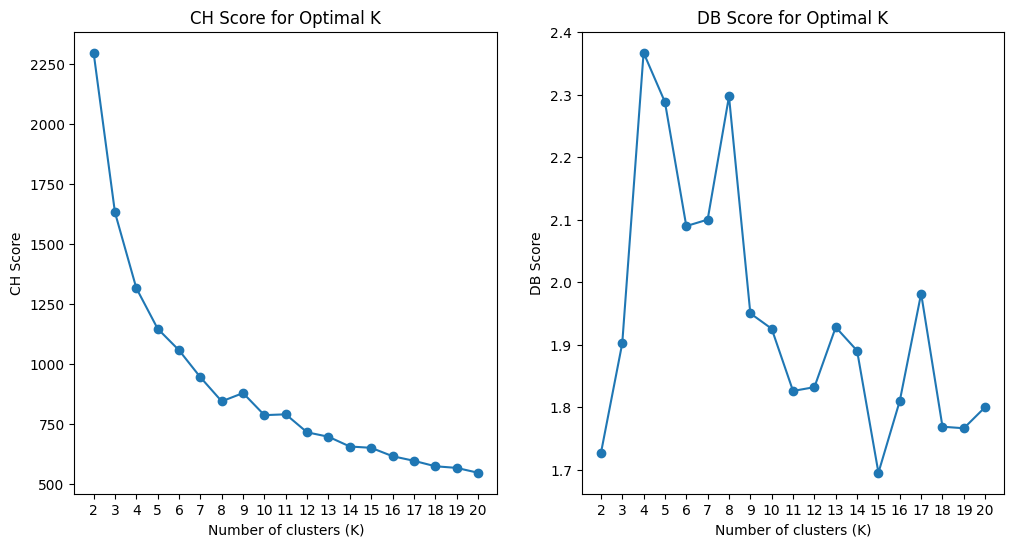

Highest Calinski-Harabasz Score:  2297.83 at 2 Clusters
Lowest Davies-Bouldin Score:  1.70 at 15 Clusters


In [38]:
# Evaluate scores for number of clusters
kmeans_eval(wq_df_unsafe_binary_red, 2, 20, 42)

# K-Means Evaluation

## Standardized Data

### All Features

In [39]:
# Run model with 2 clusters
clust_count_sd, centroids_sd, model_sum_sd, metric_sum_sd = kmeans_outputs(2, wq_df_unsafe_standardized, 42)

In [40]:
# Cluster counts
clust_count_sd

{0: 3123, 1: 3961}

In [41]:
# Cluster centroids
centroids_sd

{0: array([ 5.18405371e-01,  1.70881509e-01,  5.93848557e-01,  6.98397327e-01,
        -1.29679440e-01,  8.99461099e-01,  8.33847233e-01,  1.28486450e-01,
        -6.12123644e-04,  2.18033683e-01,  1.15823157e-02, -8.36291869e-02,
         8.46332589e-03,  5.18234385e-01,  4.77847493e-03,  8.74077783e-01,
         5.71844862e-01,  1.14680032e-02,  8.25028746e-01,  2.47977706e-02]),
 1: array([-4.08730112e-01, -1.34729350e-01, -4.68212331e-01, -5.50642477e-01,
         1.02244103e-01, -7.09168648e-01, -6.57436231e-01, -1.01303505e-01,
         4.82621091e-04, -1.71905881e-01, -9.13192933e-03,  6.59363673e-02,
        -6.67280150e-03, -4.08595300e-01, -3.76752770e-03, -6.89155495e-01,
        -4.50863798e-01, -9.04180108e-03, -6.50483407e-01, -1.95514864e-02])}

In [42]:
# Summary Means
model_sum_sd

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
Cluster,,,,,,,,,,,,,,,,,,,,
0,0.518405,0.170882,0.593849,0.698397,-0.129679,0.899461,0.833847,0.128486,-0.000612,0.218034,0.011582,-0.083629,0.008463,0.518234,0.004778,0.874078,0.571845,0.011468,0.825029,0.024798
1,-0.408730,-0.134729,-0.468212,-0.550642,0.102244,-0.709169,-0.657436,-0.101304,0.000483,-0.171906,-0.009132,0.065936,-0.006673,-0.408595,-0.003768,-0.689155,-0.450864,-0.009042,-0.650483,-0.019551


In [43]:
# Metric Scores
metric_sum_sd

{'Silhouette Score': 0.2,
 'Davies-Bouldin Index': 2.0,
 'Calinski-Harabasz Index': 1748.39}

### Reduced Features

In [44]:
# Convert to dataframe
wq_df_unsafe_standardized_red = pd.DataFrame(wq_df_unsafe_standardized_red, columns=list(wq_df_unsafe_standardized.columns[:wq_df_unsafe_standardized_red.shape[1]]))
# Run model with 2 clusters
clust_count_sdr, centroids_sdr, model_sum_sdr, metric_sum_sdr = kmeans_outputs(2, wq_df_unsafe_standardized_red, 42)

In [45]:
# Cluster counts
clust_count_sdr

{0: 3124, 1: 3960}

In [46]:
# Cluster centroids
centroids_sdr

{0: array([ 2.17916104,  0.0047966 , -0.05680329, -0.07618628, -0.01084632,
        -0.00528151,  0.01647161,  0.0453413 , -0.00961132,  0.00863777,
        -0.05453649, -0.04207038, -0.03513251, -0.02427343,  0.0616085 ,
        -0.01068577, -0.02149507]),
 1: array([-1.71813177, -0.00378182,  0.04478583,  0.0600681 ,  0.00855164,
         0.00416414, -0.01298683, -0.03574877,  0.00757792, -0.00681034,
         0.0429986 ,  0.03316986,  0.02769978,  0.01913808, -0.04857444,
         0.00842506,  0.01694751])}

In [47]:
# Summary Means
model_sum_sdr

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium
Cluster,,,,,,,,,,,,,,,,,
0,2.178521,0.004691,-0.057363,-0.076357,-0.010787,-0.005713,0.016768,0.045079,-0.009275,0.008606,-0.054582,-0.041752,-0.034994,-0.024205,0.061817,-0.010704,-0.021518
1,-1.718611,-0.003701,0.045253,0.060237,0.008509,0.004507,-0.013228,-0.035562,0.007317,-0.006789,0.043059,0.032937,0.027606,0.019095,-0.048767,0.008444,0.016976


In [48]:
# Metric Scores
metric_sum_sdr

{'Silhouette Score': 0.21,
 'Davies-Bouldin Index': 1.93,
 'Calinski-Harabasz Index': 1872.09}

## Binary Data

### All Features

In [49]:
# Run model with 2 clusters
clust_count_bin, centroids_bin, model_sum_bin, metric_sum_bin = kmeans_outputs(2, wq_df_unsafe_binary, 42)

In [50]:
# Cluster counts
clust_count_bin

{0: 3096, 1: 3988}

In [51]:
# Cluster centroids
centroids_bin

{0: array([0.18087855, 0.        , 0.87273902, 0.60755814, 0.73449612,
        0.55394057, 0.89696382, 0.32364341, 0.        , 0.77874677,
        0.86692506, 0.86434109, 0.51324289, 0.99483204, 0.77099483,
        0.05620155, 0.3875969 , 0.        , 0.84851421, 0.        ]),
 1: array([0.00451354, 0.        , 0.86108325, 0.09277834, 0.944333  ,
        0.00275827, 0.00952859, 0.26554664, 0.        , 0.5551655 ,
        0.83901705, 0.93630893, 0.5057673 , 0.52858576, 0.76278837,
        0.00125376, 0.07798395, 0.        , 0.00551655, 0.        ])}

In [52]:
# Summary Means
model_sum_bin

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium
Cluster,,,,,,,,,,,,,,,,,,,,
0,0.180879,0.0,0.872739,0.607558,0.734496,0.553941,0.896964,0.323643,0.0,0.778747,0.866925,0.864341,0.513243,0.994832,0.770995,0.056202,0.387597,0.0,0.848514,0.0
1,0.004514,0.0,0.861083,0.092778,0.944333,0.002758,0.009529,0.265547,0.0,0.555165,0.839017,0.936309,0.505767,0.528586,0.762788,0.001254,0.077984,0.0,0.005517,0.0


In [53]:
# Metric Scores
metric_sum_bin

{'Silhouette Score': 0.29,
 'Davies-Bouldin Index': 1.51,
 'Calinski-Harabasz Index': 3012.62}

### Reduced Features

In [54]:
# Convert to dataframe
wq_df_unsafe_binary_red = pd.DataFrame(wq_df_unsafe_binary_red, columns=list(wq_df_unsafe_binary.columns[:wq_df_unsafe_binary_red.shape[1]]))
# Run model with 2 clusters
clust_count_binr, centroids_binr, model_sum_binr, metric_sum_binr = kmeans_outputs(2, wq_df_unsafe_binary_red, 42)

In [55]:
# Cluster counts
clust_count_binr

{0: 3100, 1: 3984}

In [56]:
# Cluster centroids
centroids_binr

{0: array([ 8.85951260e-01,  7.76321182e-02, -6.09632984e-03,  1.42225658e-05,
         2.12185899e-03, -3.15160626e-02,  3.89000785e-02,  2.58696828e-02,
        -2.45942846e-02, -3.42934886e-02,  8.79251798e-03, -5.70796184e-03,
        -3.37299200e-03]),
 1: array([-6.89369706e-01, -6.04065176e-02,  4.74363015e-03, -1.10667555e-05,
        -1.65104489e-03,  2.45230407e-02, -3.02686354e-02, -2.01295222e-02,
         1.91371190e-02,  2.66841904e-02, -6.84156771e-03,  4.44143617e-03,
         2.62456707e-03])}

In [57]:
# Summary Means
model_sum_binr

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,viruses,lead,nitrates
Cluster,,,,,,,,,,,,,
0,0.885951,0.077632,-0.006096,0.000014,0.002122,-0.031516,0.038900,0.02587,-0.024594,-0.034293,0.008793,-0.005708,-0.003373
1,-0.689370,-0.060407,0.004744,-0.000011,-0.001651,0.024523,-0.030269,-0.02013,0.019137,0.026684,-0.006842,0.004441,0.002625


In [58]:
# Metric Scores
metric_sum_binr

{'Silhouette Score': 0.3,
 'Davies-Bouldin Index': 1.46,
 'Calinski-Harabasz Index': 3210.8}